# Disaggregation of appliances from generated load profiles

## Open questions:
- Does an appliance count as 'on' if it is active at _any_ time within a given window?

In [1]:
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Tensorflow
import tensorflow as tf
from scipy.signal import find_peaks
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Scripts
import utils

pd.set_option("display.precision", 10)
pd.set_option("display.max_columns", 500)

%matplotlib inline

c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Constants
DATA_PATH = "data/6_months"
MODEL_PATH = "models_concat/" + DATA_PATH.split("/")[-1]

In [3]:
df = pd.read_csv(f"{DATA_PATH}/data_reduced.csv", index_col=0)
df

c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Target
0,0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
15638395,15638395,2021-06-30 23:59:55,0.0,0.0,0.0,0.0,0.0,0.0
15638396,15638396,2021-06-30 23:59:56,0.0,0.0,0.0,0.0,0.0,0.0
15638397,15638397,2021-06-30 23:59:57,0.0,0.0,0.0,0.0,0.0,0.0
15638398,15638398,2021-06-30 23:59:58,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
appliances = ["Stove", "Coffee_machine", "Microwave", "Dishwasher", "Washing_machine"]

In [5]:
df.plot(y=appliances, figsize=(20, 10))

<AxesSubplot:>

Error in callback <function flush_figures at 0x0000020B8606F160> (for post_execute):


KeyboardInterrupt: 

In [6]:
df.plot(y=["Power"], figsize=(20, 10))

KeyError: "None of [Index(['Power'], dtype='object')] are in the [columns]"

<AxesSubplot:>

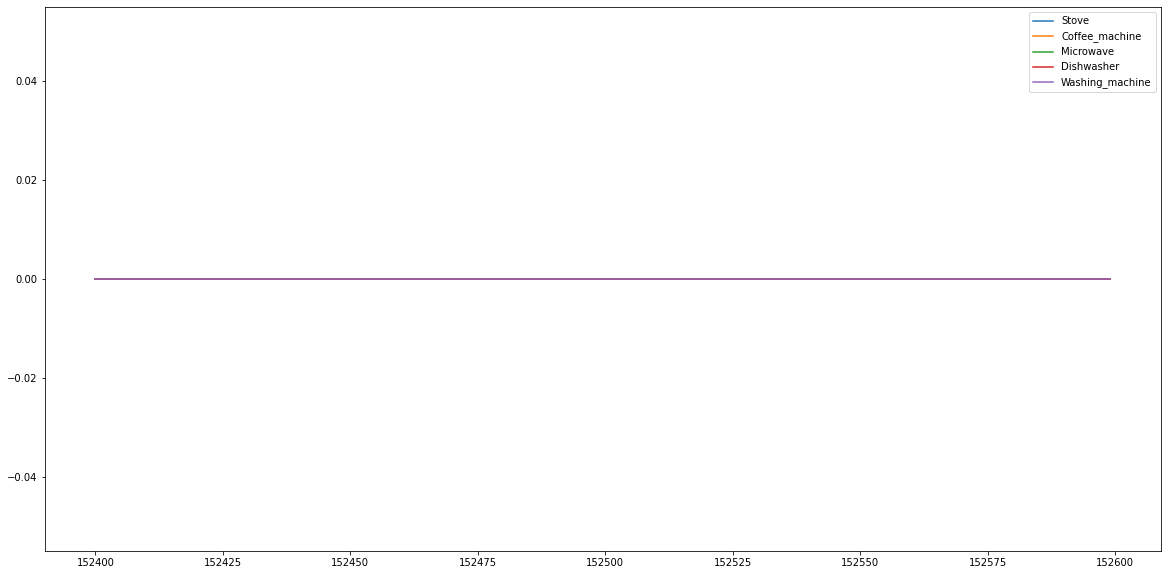

In [7]:
## microwave profile
df.iloc[152400:152600].plot(y=appliances, figsize=(20, 10))

<AxesSubplot:>

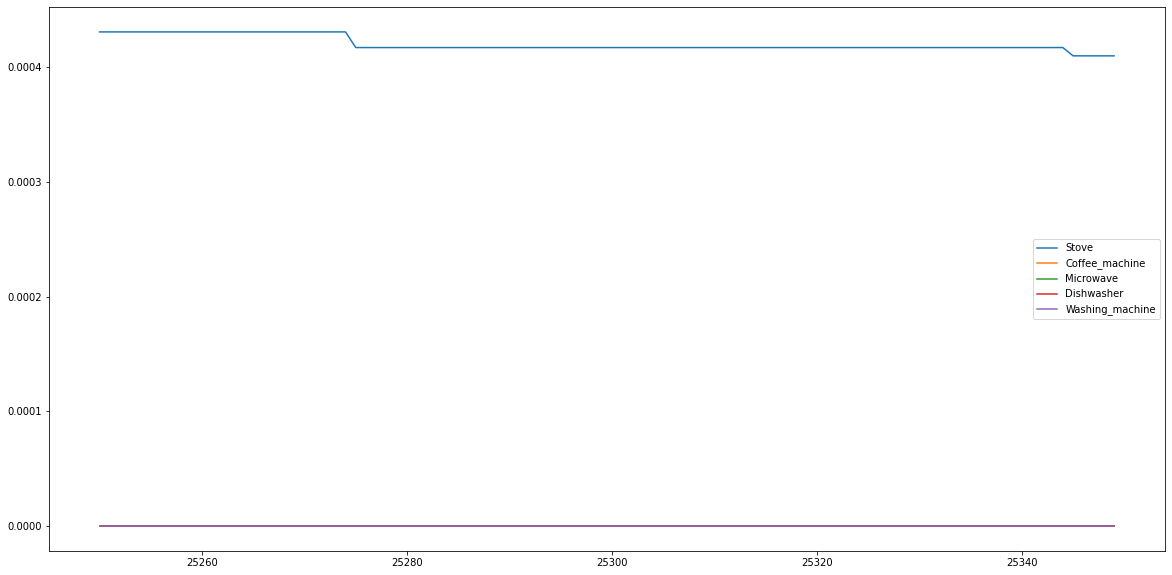

In [8]:
## why coffee machines dont work well
df.iloc[25250:25350].plot(y=appliances, figsize=(20, 10))

# Convert time series data to windowed data frame

In [7]:
window_size = 180
step = 1

In [8]:
windowed_data_path = f"{DATA_PATH}/windowed_{window_size}_step_{step}_noisy.csv"

In [9]:
df_timeseries = utils.write_or_load_windows(
    windowed_data_path, df, window_size, step, appliances
)
df_timeseries

Loading existing window file data/6_months/windowed_180_step_1_noisy.csv


c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.0001567047,0.0001387678,0.0001570701,0.0001525167,0.0001582124,0.0001363594,0.0001502016,0.0001524143,0.0001433487,0.0001599655,0.0001496477,0.0001550041,0.0001477059,0.0001462401,0.0001441854,0.0001484884,0.0001509225,0.0001599853,0.0001473093,0.0001455594,0.0001617919,0.0001459716,0.0001523487,0.0001484821,0.0001380473,0.0001502253,0.0001517571,0.0001573660,0.0001586774,0.0001377296,0.0001396824,0.0001418023,0.0001519152,0.0001604267,0.0001485330,0.0001453387,0.0001598725,0.0001496837,0.0001537660,0.0001357789,0.0001529094,0.0001514478,0.0001554339,0.0001562052,0.0001525792,0.0001392569,0.0001384204,0.0001432295,0.0001434882,0.0001396081,0.0001375167,0.0001530931,0.0001387494,0.0001622797,0.0001546164,0.0001497845,0.0001528894,0.0001494679,0.0001522063,0.0001457176,0.0001460168,0.0001414556,0.0001460309,0.0001465982,0.0001447985,0.0001639070,0.0001328957,0.0001519047,0.0001398323,0.0001590326,0.0001514081,0.0001529710,0.0001351505,0.0001478810,0.0001428016,0.0001473621,0.0001448259,0.0001506248,0.0001442177,0.0001488766,0.0001504755,0.0001541620,0.0001495985,0.0001552328,0.0001437602,0.0001449125,0.0001461283,0.0001600534,0.0001423270,0.0001381453,0.0001671616,0.0001470570,0.0001480087,0.0001534178,0.0001492486,0.0001351401,0.0001442496,0.0001489050,0.0001325454,0.0001488421,0.0001400687,0.0001435467,0.0001567003,0.0001596137,0.0001479796,0.0001445594,0.0001491363,0.0001454473,0.0001548101,0.0001414508,0.0001343948,0.0001456909,0.0001399058,0.0001557608,0.0001504713,0.0001472402,0.0001394553,0.0001523024,0.0001518415,0.0001361274,0.0001485977,0.0001379649,0.0001441583,0.0001482136,0.0001355378,0.0001546165,0.0001394558,0.0001587925,0.0001598724,0.0001473018,0.0001499426,0.0001482724,0.0001462232,0.0001441178,0.0001472607,0.0001405876,0.0001454499,0.0001411768,0.0001459480,0.0001391442,0.0001424453,0.0001386773,0.0001334870,0.0001477652,0.0001462036,0.0001455096,0.0001565148,0.0001584786,0.0001462157,0.0001542855,0.0001566466,0.0001514815,0.0001464976,0.0001465478,0.0001352764,0.0001516162,0.0001488211,0.0001377643,0.0001548558,0.

## Undersampling

In [10]:
counts = []
for appliance in appliances:
    count = utils.count_non_zero_rows(df_timeseries, appliance)
    counts.append(count)
    print(appliance, count)

max_class_freq = max(counts)
print(f"Highest class count --->  {max_class_freq}")

Stove 178021
Coffee_machine 35674
Microwave 49561
Dishwasher 292795
Washing_machine 109558
Highest class count --->  292795


In [11]:
df_sampled_negative = df_timeseries.loc[
    (df_timeseries["Stove"] == 0)
    & (df_timeseries["Coffee_machine"] == 0)
    & (df_timeseries["Microwave"] == 0)
    & (df_timeseries["Dishwasher"] == 0)
    & (df_timeseries["Washing_machine"] == 0)
].sample(max_class_freq)
df_sampled_negative

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
2449334,0.0000243328,0.0000266680,0.0000225152,0.0000254480,0.0000214327,0.0000266253,0.0000231332,0.0000227907,0.0000253675,0.0000236742,0.0000245860,0.0000252511,0.0000222621,0.0000230538,0.0000256964,0.0000265973,0.0000239698,0.0000241236,0.0000249994,0.0000252113,0.0000250032,0.0000219404,0.0000253339,0.0000238879,0.0000282335,0.0000242519,0.0000272597,0.0000248754,0.0000236999,0.0000263490,0.0000255396,0.0000252695,0.0000229569,0.0000242171,0.0000221337,0.0000241999,0.0000244689,0.0000224680,0.0000250291,0.0000254102,0.0000214277,0.0000261294,0.0000248972,0.0000251589,0.0000254876,0.0000277269,0.0000231222,0.0000241777,0.0000226288,0.0000262969,0.0000262755,0.0000238537,0.0000272381,0.0000229768,0.0000219648,0.0000247612,0.0000254303,0.0000241853,0.0000229450,0.0000241979,0.0000229387,0.0000248500,0.0000259199,0.0000254917,0.0000250981,0.0000261269,0.0000264101,0.0000250544,0.0000235564,0.0000245144,0.0000248693,0.0000248227,0.0000250781,0.0000260185,0.0000231087,0.0000233500,0.0000258983,0.0000249577,0.0000241059,0.0000247142,0.0000255887,0.0000242092,0.0000227289,0.0000231751,0.0000246222,0.0000234943,0.0000273959,0.0000235766,0.0000223000,0.0000240235,0.0000251359,0.0000229947,0.0000228492,0.0000225389,0.0000256838,0.0000226345,0.0000259844,0.0000248854,0.0000239533,0.0000241891,0.0000238468,0.0000247699,0.0000245424,0.0000229452,0.0000239648,0.0000240232,0.0000237917,0.0000242746,0.0000246694,0.0000262729,0.0000243651,0.0000225872,0.0000232937,0.0000245613,0.0000240681,0.0000253182,0.0000228231,0.0000236070,0.0000246177,0.0000258059,0.0000273513,0.0000256322,0.0000262670,0.0000242796,0.0000243579,0.0000246429,0.0000258621,0.0000242984,0.0000254617,0.0000229306,0.0000248577,0.0000285781,0.0000241987,0.0000248511,0.0000267227,0.0000236669,0.0000250527,0.0000231261,0.0000248335,0.0000245207,0.0000250704,0.0000232278,0.0000228090,0.0000255026,0.0000237298,0.0000227219,0.0000234303,0.0000232676,0.0000231661,0.0000260654,0.0000221550,0.0000238901,0.0000237257,0.0000246058,0.0000261931,0.0000263532,0.0000223598,0.0000235248,0.0000239

In [12]:
drop_indices = df_timeseries.loc[
    (df_timeseries["Stove"] == 0)
    & (df_timeseries["Coffee_machine"] == 0)
    & (df_timeseries["Microwave"] == 0)
    & (df_timeseries["Dishwasher"] == 0)
    & (df_timeseries["Washing_machine"] == 0)
].index
df_timeseries = df_timeseries.drop(drop_indices)
df_timeseries

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
5801,0.0001150814,0.0001028167,0.0000982280,0.0000978033,0.0001049534,0.0001090628,0.0001222314,0.0000908688,0.0001138711,0.0001016264,0.0000913862,0.0001012317,0.0001006560,0.0000999293,0.0001067863,0.0001009807,0.0000987747,0.0001045543,0.0001277292,0.0001207036,0.0001148617,0.0001050584,0.0001081868,0.0001076230,0.0001085562,0.0001050742,0.0001136484,0.0000998194,0.0001045620,0.0001023783,0.0000945825,0.0000982752,0.0001035310,0.0001204556,0.0000964053,0.0001121859,0.0000955048,0.0000894152,0.0001089969,0.0001183245,0.0001017188,0.0001058321,0.0001022378,0.0001040601,0.0001151654,0.0001085038,0.0000975390,0.0001033449,0.0001153765,0.0001198990,0.0001044204,0.0000937835,0.0001042194,0.0000970797,0.0001005553,0.0001013076,0.0001139331,0.0001000349,0.0001076008,0.0001075074,0.0001045950,0.0001107857,0.0001113337,0.0001045678,0.0000912397,0.0001009663,0.0000951903,0.0001028779,0.0001050292,0.0001167737,0.0001105582,0.0000998473,0.0001025445,0.0001040329,0.0000891352,0.0001162969,0.0001089656,0.0001018061,0.0000983806,0.0001138651,0.0001070411,0.0001064470,0.0001036650,0.0001059379,0.0000933205,0.0001061110,0.0001002123,0.0001161186,0.0000997755,0.0001154568,0.0001044540,0.0001131706,0.0001146369,0.0001051062,0.0001005692,0.0001031914,0.0001045182,0.0001106083,0.0001016332,0.0001095336,0.0001009123,0.0001110059,0.0001032681,0.0001063872,0.0001094074,0.0001043231,0.0000893283,0.0001084087,0.0001080175,0.0001046406,0.0001037662,0.0001105248,0.0001101214,0.0001003734,0.0001111418,0.0001012965,0.0001110380,0.0001076332,0.0001062325,0.0001269977,0.0001189380,0.0001113719,0.0001107640,0.0001022852,0.0001023609,0.0001100178,0.0001087612,0.0000941662,0.0001178399,0.0001200536,0.0000974293,0.0001136230,0.0001051876,0.0001167966,0.0001080765,0.0001124502,0.0001070541,0.0001138840,0.0001112675,0.0001071105,0.0001083894,0.0000972269,0.0001045643,0.0001079144,0.0001057618,0.0001125989,0.0001082620,0.0000911013,0.0001131629,0.0001003787,0.0001018255,0.0001119543,0.0001060228,0.0001179146,0.0001033008,0.0001026716,0.0001022579,0.0000965914,0.0001036480

In [13]:
df_timeseries = pd.concat([df_sampled_negative, df_timeseries])
df_timeseries.reset_index(inplace=True)
df_timeseries.drop(columns=["index"], inplace=True)
df_timeseries

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.0000243328,0.0000266680,0.0000225152,0.0000254480,0.0000214327,0.0000266253,0.0000231332,0.0000227907,0.0000253675,0.0000236742,0.0000245860,0.0000252511,0.0000222621,0.0000230538,0.0000256964,0.0000265973,0.0000239698,0.0000241236,0.0000249994,0.0000252113,0.0000250032,0.0000219404,0.0000253339,0.0000238879,0.0000282335,0.0000242519,0.0000272597,0.0000248754,0.0000236999,0.0000263490,0.0000255396,0.0000252695,0.0000229569,0.0000242171,0.0000221337,0.0000241999,0.0000244689,0.0000224680,0.0000250291,0.0000254102,0.0000214277,0.0000261294,0.0000248972,0.0000251589,0.0000254876,0.0000277269,0.0000231222,0.0000241777,0.0000226288,0.0000262969,0.0000262755,0.0000238537,0.0000272381,0.0000229768,0.0000219648,0.0000247612,0.0000254303,0.0000241853,0.0000229450,0.0000241979,0.0000229387,0.0000248500,0.0000259199,0.0000254917,0.0000250981,0.0000261269,0.0000264101,0.0000250544,0.0000235564,0.0000245144,0.0000248693,0.0000248227,0.0000250781,0.0000260185,0.0000231087,0.0000233500,0.0000258983,0.0000249577,0.0000241059,0.0000247142,0.0000255887,0.0000242092,0.0000227289,0.0000231751,0.0000246222,0.0000234943,0.0000273959,0.0000235766,0.0000223000,0.0000240235,0.0000251359,0.0000229947,0.0000228492,0.0000225389,0.0000256838,0.0000226345,0.0000259844,0.0000248854,0.0000239533,0.0000241891,0.0000238468,0.0000247699,0.0000245424,0.0000229452,0.0000239648,0.0000240232,0.0000237917,0.0000242746,0.0000246694,0.0000262729,0.0000243651,0.0000225872,0.0000232937,0.0000245613,0.0000240681,0.0000253182,0.0000228231,0.0000236070,0.0000246177,0.0000258059,0.0000273513,0.0000256322,0.0000262670,0.0000242796,0.0000243579,0.0000246429,0.0000258621,0.0000242984,0.0000254617,0.0000229306,0.0000248577,0.0000285781,0.0000241987,0.0000248511,0.0000267227,0.0000236669,0.0000250527,0.0000231261,0.0000248335,0.0000245207,0.0000250704,0.0000232278,0.0000228090,0.0000255026,0.0000237298,0.0000227219,0.0000234303,0.0000232676,0.0000231661,0.0000260654,0.0000221550,0.0000238901,0.0000237257,0.0000246058,0.0000261931,0.0000263532,0.0000223598,0.0000235248,0.0000239796,0.

In [14]:
samples = [x for i, x in enumerate(df_timeseries.columns) if x not in appliances]
X = df_timeseries.loc[:, samples]
y = df_timeseries.loc[:, appliances]

## Possible time-/frequency-based features
- min
- max
- num peaks
- stddev
- variance
- mean
- median
- sum
- mean change
- rms

inspiration taken from tsfresh

In [15]:
params = ["centroid", "variance", "skew", "kurtosis"]
fft_params = [{"aggtype": param} for param in params]
fft_params

[{'aggtype': 'centroid'},
 {'aggtype': 'variance'},
 {'aggtype': 'skew'},
 {'aggtype': 'kurtosis'}]

In [16]:
df_feature_engineering = pd.read_csv(f"{DATA_PATH}/new_features.csv", index_col=0)
df_feature_engineering

,min,max,num_peaks,stddev,variance,mean,median,sum,mean_change,root_mean_square,freq_centroid,freq_variance,freq_skew,freq_kurtosis
0,0.0000601730,0.0000874501,56,0.0000047225,2.2302226042e-11,0.0000725508,0.0000725446,0.0130591527,0.0000000259,0.0000727044,12.1580735239,563.6924110228,1.8187498159,5.1160859586
1,0.0000206731,0.0000284521,58,0.0000014899,2.2197276744e-12,0.0000246438,0.0000246852,0.0044358848,-0.0000000036,0.0000246888,12.9004344395,643.1288225067,1.8097184937,5.0229824888
2,0.0001756614,0.0002576883,59,0.0000154632,2.3911157577e-10,0.0002060476,0.0002061185,0.0370885594,-0.0000001114,0.0002066270,13.8452868663,629.3210910427,1.6451557922,4.5731735852
3,0.0000209220,0.0000291697,64,0.0000013469,1.8141298069e-12,0.0000245256,0.0000246802,0.0044146004,0.0000000071,0.0000245625,11.3413241581,571.1051613693,2.0403706185,5.9505657577
4,0.0000203794,0.0000504565,57,0.0000110010,1.2102147198e-10,0.0000322384,0.0000254801,0.0058029110,0.0000001062,0.0000340637,10.5046883503,468.6680298311,2.2919743816,7.3227985531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865729,0.0005366705,0.0009216853,55,0.0000808887,6.5429766319e-09,0.0006860606,0.0006882801,0.1234909032,0.0000003885,0.0006908126,10.6761581929,508.1347249026,2.1375749526,6.4784670706
865730,0.0005366705,0.0009216853,56,0.0000808891,6.5430503809e-09,0.0006860614,0.0006882801,0.1234910445,-0.0000001297,0.0006908135,10.6756838621,508.1123742912,2.1376486278,6.4788035998
865731,0.0005366705,0.0009216853,55,0.0000807523,6.5209329246e-09,0.0006858434,0.0006882801,0.1234518204,-0.0000003981,0.0006905810,10.6575078291,505.2509344322,2.1357834431,6.4793677856
865732,0.0005366705,0.0009216853,55,0.0000805364,6.4861162660e-09,0.0006856361,0.0006882801,0.1234144917,-0.0000001567,0.0006903499,10.6692814863,507.5566580650,2.1369138415,6.4790950237


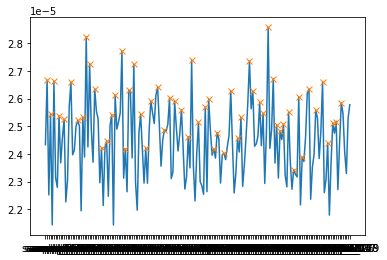

In [17]:
row = X.iloc[0]
peaks = find_peaks(row, prominence=(None, 0.5))[0]
plt.plot(row)
plt.plot(peaks, row[peaks], "x")

# Train-test split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [19]:
from sklearn.preprocessing import StandardScaler

window_scaler = StandardScaler()
X_train = window_scaler.fit_transform(X_train)
X_test = window_scaler.transform(X_test)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=False
)

In [21]:
X_train_add, X_test_add, y_train_add, _ = train_test_split(
    df_feature_engineering, y, test_size=0.2, random_state=42, shuffle=False
)

In [22]:
add_scaler = StandardScaler()
X_train_add = add_scaler.fit_transform(X_train_add)
X_test_add = add_scaler.transform(X_test_add)

In [23]:
X_train_add, X_val_add, _, _ = train_test_split(
    X_train_add, y_train_add, test_size=0.15, random_state=42, shuffle=False
)

# Modeling

In [24]:
X_train.shape

(588698, 180)

In [25]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import AveragePooling1D, Conv1D, MaxPooling1D
from keras.models import Sequential

In [26]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
EPOCHS = 100
BATCH_SIZE = 64

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, verbose=2, restore_best_weights=True
    ),
]

# Architecture insights
- Best model so far is true_DLO_doppelte_filter_60er_kernel_model with batch size 256, window size 180 with f1 scores between 88-96%, accuracy ~87% and LR at 5e-07
- GlobalMaxPooling seems to improve results on strongly imbalanced classes but worsens performance on "main" classes

In [28]:
from keras.layers import *


def create_model():
    kernel_size = 60
    filter_size = 128
    mlp_neuron_count = 128
    dropout = 0.3

    input_layer = keras.layers.Input(shape=(window_size, 1))

    conv1 = keras.layers.Conv1D(
        filters=filter_size, kernel_size=kernel_size, padding="same"
    )(input_layer)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.MaxPool1D()(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(dropout)(conv1)

    conv2 = keras.layers.Conv1D(
        filters=filter_size, kernel_size=kernel_size, padding="same"
    )(conv1)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.MaxPool1D()(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(dropout)(conv2)

    conv3 = keras.layers.Conv1D(
        filters=filter_size, kernel_size=kernel_size, padding="same"
    )(conv2)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.MaxPool1D()(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(dropout)(conv3)

    ## Feature engineered data through MLP

    input_layer_add = keras.layers.Input(shape=(14,))

    dense_add1 = keras.layers.Dense(mlp_neuron_count, activation="relu")(
        input_layer_add
    )
    dense_add1 = keras.layers.BatchNormalization()(dense_add1)

    dense_add2 = keras.layers.Dense(mlp_neuron_count, activation="relu")(dense_add1)
    dense_add2 = keras.layers.BatchNormalization()(dense_add2)

    dense_add3 = keras.layers.Dense(mlp_neuron_count, activation="relu")(dense_add2)
    dense_add3 = keras.layers.BatchNormalization()(dense_add3)

    #     conv4 = keras.layers.Conv1D(
    #         filters=filter_size, kernel_size=kernel_size, padding="same"
    #     )(conv3)
    #     conv4 = keras.layers.ReLU()(conv4)
    #     conv4 = keras.layers.MaxPool1D()(conv4)
    #     conv4 = keras.layers.BatchNormalization()(conv4)
    #     conv4 = keras.layers.Dropout(dropout)(conv4)

    #     conv5 = keras.layers.Conv1D(
    #         filters=filter_size, kernel_size=kernel_size, padding="same"
    #     )(conv4)
    #     conv5 = keras.layers.ReLU()(conv5)
    #     conv5 = keras.layers.BatchNormalization()(conv5)
    #     conv5 = keras.layers.Dropout(dropout)(conv5)

    gap = keras.layers.GlobalMaxPooling1D()(conv3)

    concat = keras.layers.Concatenate()([gap, dense_add3])

    output_layer = keras.layers.Dense(len(appliances), activation="sigmoid")(concat)

    return keras.models.Model(
        inputs=[input_layer, input_layer_add], outputs=output_layer
    )

In [29]:
LR = 0.000008
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
f"Setting learning rate to {LR}"

'Setting learning rate to 8e-06'

In [30]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [31]:
model = create_model()

In [32]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["AUC", "binary_accuracy"])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 180, 128)     7808        ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 180, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 90, 128)      0           ['re_lu[0][0]']                  
                                                                                              

In [34]:
history = model.fit(
    (X_train, X_train_add),
    y_train,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    validation_data=((X_val, X_val_add), y_val),
    epochs=EPOCHS,
)

Epoch 1/100
9199/9199 [==============================] - 208s 21ms/step - loss: 0.2147 - auc: 0.9156 - binary_accuracy: 0.9074 - val_loss: 0.3796 - val_auc: 0.8640 - val_binary_accuracy: 0.8165 - lr: 8.0000e-06
Epoch 2/100
9199/9199 [==============================] - 191s 21ms/step - loss: 0.1741 - auc: 0.9473 - binary_accuracy: 0.9227 - val_loss: 0.3518 - val_auc: 0.8883 - val_binary_accuracy: 0.8378 - lr: 8.0000e-06
Epoch 3/100
9199/9199 [==============================] - 175s 19ms/step - loss: 0.1601 - auc: 0.9558 - binary_accuracy: 0.9294 - val_loss: 0.3379 - val_auc: 0.8966 - val_binary_accuracy: 0.8410 - lr: 8.0000e-06
Epoch 4/100
9199/9199 [==============================] - 175s 19ms/step - loss: 0.1502 - auc: 0.9612 - binary_accuracy: 0.9341 - val_loss: 0.3399 - val_auc: 0.8951 - val_binary_accuracy: 0.8339 - lr: 8.0000e-06
Epoch 5/100
9199/9199 [==============================] - 175s 19ms/step - loss: 0.1430 - auc: 0.9649 - binary_accuracy: 0.9376 - val_loss: 0.3348 - val_auc:

In [35]:
THRESHOLD = 0.5
y_pred = model.predict((X_test, X_test_add))
y_pred[y_pred >= THRESHOLD] = 1
y_pred[y_pred < THRESHOLD] = 0
y_pred

5411/5411 [==============================] - 21s 4ms/step


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [36]:
test_loss, test_auc, test_acc = model.evaluate((X_test, X_test_add), y_test)

print("Test AUC", test_auc)
print("Test Acc", test_acc)
print("Test loss", test_loss)

5411/5411 [==============================] - 38s 7ms/step - loss: 0.2695 - auc: 0.9403 - binary_accuracy: 0.8919
Test AUC 0.94028240442276
Test Acc 0.8918833136558533
Test loss 0.2694788873195648


In [37]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5774630805038493

In [38]:
MODEL_NAME = "DLO_128,128,128_60er_kernel_GlobalMaxPool,3x128_Dense_model_noisy"

In [44]:
model.save(f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}")

INFO:tensorflow:Assets written to: models_concat/6_months/DLO_128,128,128_60er_kernel_GlobalMaxPool,3x128_Dense_model_noisy/LR=8e-06,Epochs=100,BATCH=64\assets


INFO:tensorflow:Assets written to: models_concat/6_months/DLO_128,128,128_60er_kernel_GlobalMaxPool,3x128_Dense_model_noisy/LR=8e-06,Epochs=100,BATCH=64\assets


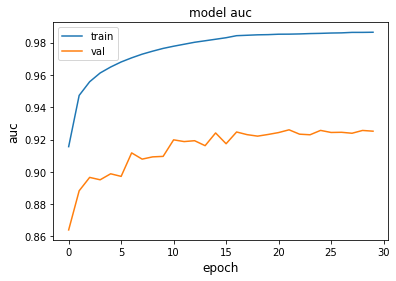

In [45]:
metric = "auc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.savefig(f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}")
plt.show()
plt.close()

In [41]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

print(
    classification_report(y_test, y_pred, target_names=appliances, zero_division=False)
)

                 precision    recall  f1-score   support

          Stove       0.79      0.93      0.85     49722
 Coffee_machine       0.70      0.90      0.79     10514
      Microwave       0.65      0.85      0.74     15220
     Dishwasher       0.81      0.65      0.72     93140
Washing_machine       0.85      0.72      0.78     41706

      micro avg       0.79      0.76      0.77    210302
      macro avg       0.76      0.81      0.78    210302
   weighted avg       0.80      0.76      0.77    210302
    samples avg       0.77      0.78      0.75    210302



Accuracy: 0.9075871946958365


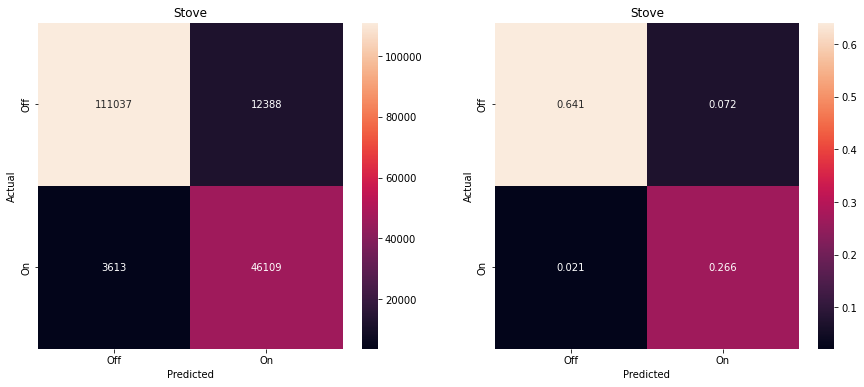

Accuracy: 0.9705048311550302


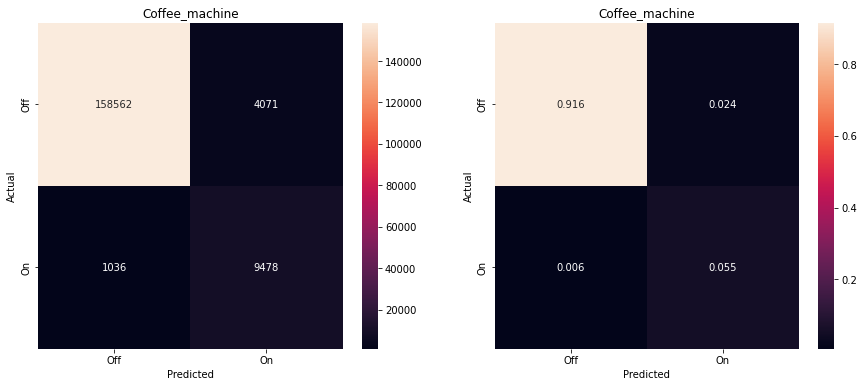

Accuracy: 0.9470449964481048


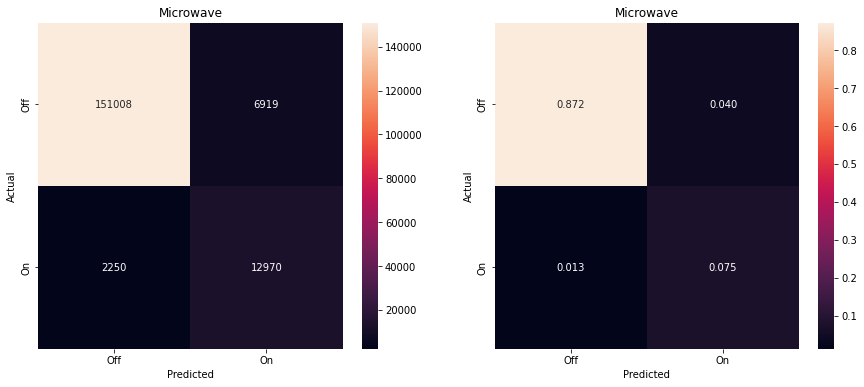

Accuracy: 0.7319560835590567


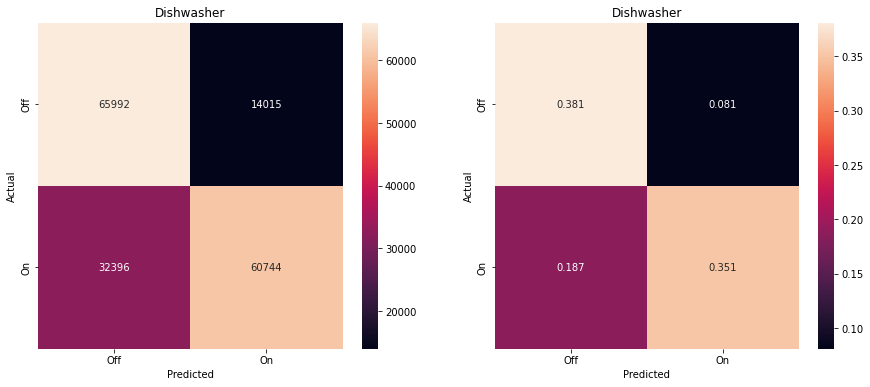

Accuracy: 0.902319993993543


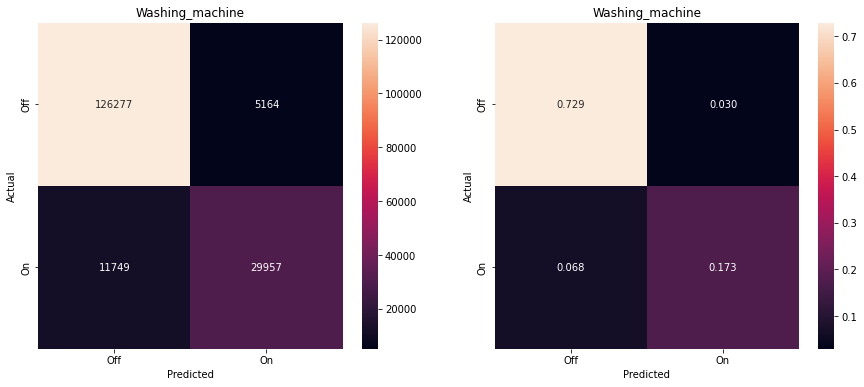

In [42]:
columns = ["Off", "On"]
for idx, item in enumerate(mcm):
    tn, fp, fn, tp = item.ravel()
    print(f"Accuracy: {(tp+tn)/(tn+fp+fn+tp)}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    heat = sns.heatmap(
        item, annot=True, fmt="1", xticklabels=columns, yticklabels=columns, ax=ax1
    )
    norm_item = item.astype("float") / item.sum(axis=None)
    norm_heat = sns.heatmap(
        norm_item,
        annot=True,
        fmt=".3f",
        xticklabels=columns,
        yticklabels=columns,
        ax=ax2,
    )
    for ax in [ax1, ax2]:
        ax.set_title(appliances[idx])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.show()